# Baseline Classifiers

How do we know if our neural networks are good? Is deep learning just a fad? Before we begin to explore neural networks, it'd be good to have other classifiers that act as a baseline performance.

In this section, I train the following classifiers and test them on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset:

- k-Nearest Neighbours (27.6%)
- **Multiclass Support Vector Machines (37.8%)**
- Softmax (37.4%)

In [198]:
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


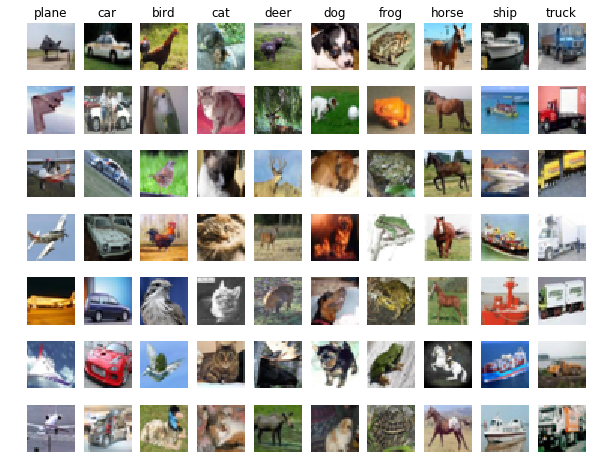

In [200]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [201]:
# Subsample the data for more efficient code execution in this exercise

num_training = 10000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
print X_train.shape, X_test.shape


(10000, 32, 32, 3) (1000, 32, 32, 3)


In [202]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(10000, 3072) (1000, 3072)


## k-Nearest Neighbour (kNN) 


- Uses L2 Euclidean distance to determine similarity of images
- During training, kNNtakes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transferring the labels of the k most similar training examples
- The value of k is cross-validated (using k-fold cross validation)

Accuracy:  27.6%

In [203]:
from baseline_classifiers.classifiers import KNearestNeighbor

In [204]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# split training examples into folds
X_train_folds=np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# A dictionary holding the accuracies for different values of k 
k_accuracy = {}
max_accuracy = 0.0
max_k = None
best_model = None

for k in k_choices:
    k_accuracy[k] = []
    for n in range(num_folds):
        # split into training and test sets
        X_train_val = np.vstack(X_train_folds[:n] + X_train_folds[n+1:])
        y_train_val = np.hstack(y_train_folds[:n] + y_train_folds[n+1:])
        X_test_val = X_train_folds[n]
        y_test_val = y_train_folds[n]
        
        # train model
        classifier = KNearestNeighbor()
        classifier.train(X_train_val, y_train_val) 
        dists = classifier.compute_distances(X_test_val) # computes L2 distances
        
        # calculate accuracy for current k
        y_pred = classifier.predict_labels(dists, k) # predict labels
        accuracy = np.mean(y_pred == y_test_val) 
        
        k_accuracy[k].append(accuracy)
    
    # determine average mean over all the folds
    accuracy_mean = np.mean(k_accuracy[k])
    k_accuracy[k].append(accuracy_mean)
    
    # stores optimal results
    if accuracy_mean > max_accuracy:
            max_accuracy = accuracy_mean
            max_k = k
            best_model = classifier

# Print out the computed accuracies
for k in sorted(k_accuracy):
    print 'k = %d, accuracy = %f' % (k, k_accuracy[k][-1])

k = 1, accuracy = 0.281300
k = 3, accuracy = 0.274600
k = 5, accuracy = 0.285900
k = 8, accuracy = 0.287700
k = 10, accuracy = 0.284900
k = 12, accuracy = 0.284800
k = 15, accuracy = 0.283200
k = 20, accuracy = 0.285800
k = 50, accuracy = 0.272900
k = 100, accuracy = 0.261900


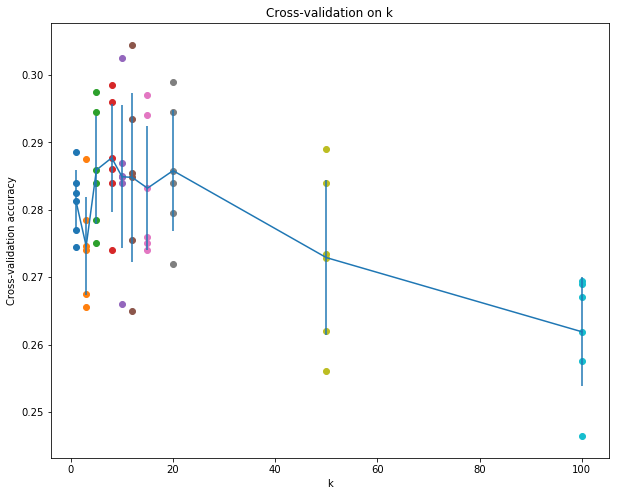

In [205]:
# plot cross-validation accuracy against k
for k in k_choices:
    accuracies = k_accuracy[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracy.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracy.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [206]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=max_k)

# Evaluate the best kNN on test set
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'k-value used: %d' % max_k
print 'Got %d / %d correct' % (num_correct, num_test)
print 'Final test set accuracy using kNN: %f' % accuracy

k-value used: 8
Got 276 / 1000 correct
Final test set accuracy using kNN: 0.276000


## Multiclass Support Vector Machine (SVM) 

Think of SVM as mapping each training instance to a point in a multidimensional space, and then determining the hyperplane that best divides each point into their respective categories.

Accuracy:  37.8%

In [207]:
from baseline_classifiers.classifiers.linear_classifier import *

In [208]:
# Preprocessing: subtract the mean image
# Compute the image mean based on the training data, and subtract from train and test data
mean_image = np.mean(X_train, axis=0)

X_train -= mean_image
X_test -= mean_image

# append the bias dimension of ones (i.e. bias trick) so that SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

#split training set into training and validation sets
mask = range(9000, 10000)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(9000)
X_train = X_train[mask]
y_train = y_train[mask]

In [209]:
# Tune hyperparameters using validation set

learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7]
regularization_strengths = [1e3, 2e3, 3e3, 4e3, 5e3, 6e3, 7e3]

# A dictionary holding (training_accuracy, validation_accuracy) 
# for different (learning_rate, regularisation_strength)
results = {}
best_accuracy = -1   # The highest validation accuracy that we have seen so far.
best_params = (None, None)
best_svm = None # The LinearSVM object that achieved the highest validation rate.


for lr in learning_rates:
    for reg in regularisation_strengths:
        
        # train model
        model = LinearSVM()
        model.train(X_train, y_train, learning_rate=lr, reg=reg, 
                                      num_iters=1500, verbose=False)
        
        # training accuracy
        y_train_pred = model.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        # validation accuracy
        y_val_pred = model.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (training_accuracy, validation_accuracy)
        
        # stores optimal results
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_params = (lr, reg)
            best_svm = model
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)

    
print 'Best validation accuracy achieved during cross-validation: %f' % best_accuracy
lr, reg = best_params
print 'Learning rate: %e, regularisation strength: %e' % (lr, reg)

lr 1.000000e-07 reg 1.000000e-03 train accuracy: 0.323667 val accuracy: 0.317000
lr 1.000000e-07 reg 1.000000e-02 train accuracy: 0.317222 val accuracy: 0.323000
lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.318111 val accuracy: 0.301000
lr 1.000000e-07 reg 1.000000e+00 train accuracy: 0.314889 val accuracy: 0.296000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.319778 val accuracy: 0.284000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.327778 val accuracy: 0.313000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.325000 val accuracy: 0.301000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.393667 val accuracy: 0.365000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.376333 val accuracy: 0.361000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.319333 val accuracy: 0.319000
lr 2.000000e-07 reg 1.000000e-03 train accuracy: 0.350444 val accuracy: 0.311000
lr 2.000000e-07 reg 1.000000e-02 train accuracy: 0.353222 val accuracy: 0.305000
lr 2.000000e-07 reg 1.000000

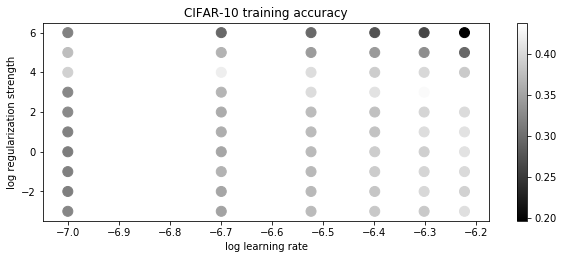

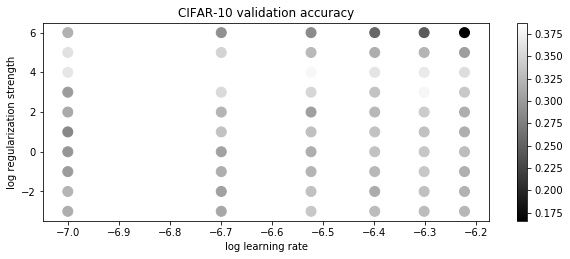

In [210]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()
print '\n'

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

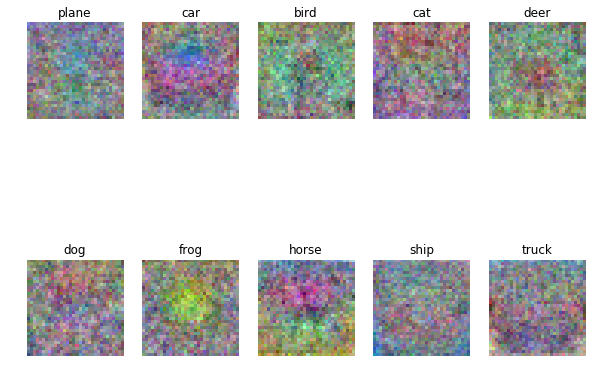

In [211]:
# Visualize the learned weights for each class.

w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [212]:
# Evaluate the best svm on test set

y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'Final test set accuracy using SVM: %f' % test_accuracy

Final test set accuracy using SVM: 0.378000


## Softmax Classifier

This is essentially a multiclass logistic regression using cross entropy cost. Softmax function is used to squash a vector of values to have values between zero and one, that all sum to one. This enables us to have a probabilistic interpretation of the eventual activation values.

Accuracy: 37.4%

In [214]:
# Tune hyperparameters using validation set

learning_rates = np.logspace(-10, 10, 10)
regularisation_strengths =  np.logspace(-3, 6, 10)

# A dictionary holding (training_accuracy, validation_accuracy) 
# for different (learning_rate, regularisation_strength)
results = {}
best_accuracy = -1   # The highest validation accuracy that we have seen so far.
best_params = (None, None)
best_softmax = None # The LinearSVM object that achieved the highest validation rate.


for lr in learning_rates:
    for reg in regularisation_strengths:
        
        # train model
        model = Softmax()
        model.train(X_train, y_train, learning_rate=lr, reg=reg, 
                                      num_iters=1500, verbose=False)
        
        # training accuracy
        y_train_pred = model.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        # validation accuracy
        y_val_pred = model.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (training_accuracy, validation_accuracy)
        
        # stores optimal results
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_params = (lr, reg)
            best_softmax = model
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)

    
print 'Best validation accuracy achieved during cross-validation: %f' % best_accuracy
lr, reg = best_params
print 'Learning rate: %e, regularisation strength: %e' % (lr, reg)

lr 1.000000e-10 reg 1.000000e-03 train accuracy: 0.079889 val accuracy: 0.072000
lr 1.000000e-10 reg 1.000000e-02 train accuracy: 0.098444 val accuracy: 0.095000
lr 1.000000e-10 reg 1.000000e-01 train accuracy: 0.088667 val accuracy: 0.104000
lr 1.000000e-10 reg 1.000000e+00 train accuracy: 0.092667 val accuracy: 0.089000
lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.069000 val accuracy: 0.064000
lr 1.000000e-10 reg 1.000000e+02 train accuracy: 0.100000 val accuracy: 0.091000
lr 1.000000e-10 reg 1.000000e+03 train accuracy: 0.101778 val accuracy: 0.112000
lr 1.000000e-10 reg 1.000000e+04 train accuracy: 0.084222 val accuracy: 0.093000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.091556 val accuracy: 0.096000
lr 1.000000e-10 reg 1.000000e+06 train accuracy: 0.123556 val accuracy: 0.117000
lr 1.668101e-08 reg 1.000000e-03 train accuracy: 0.182222 val accuracy: 0.175000
lr 1.668101e-08 reg 1.000000e-02 train accuracy: 0.166111 val accuracy: 0.173000
lr 1.668101e-08 reg 1.000000

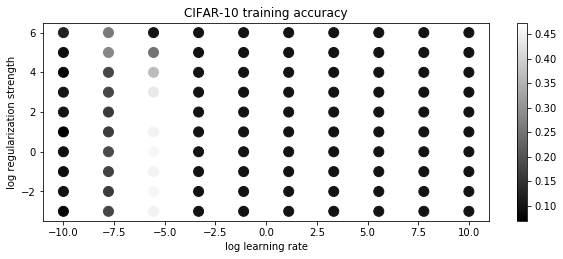

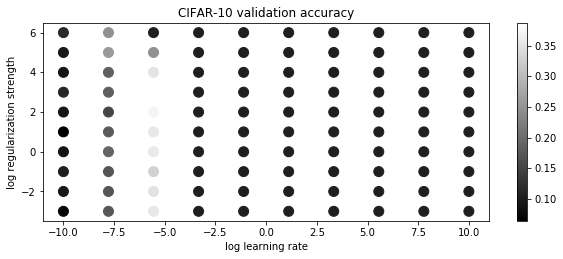

In [215]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()

print '\n'

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

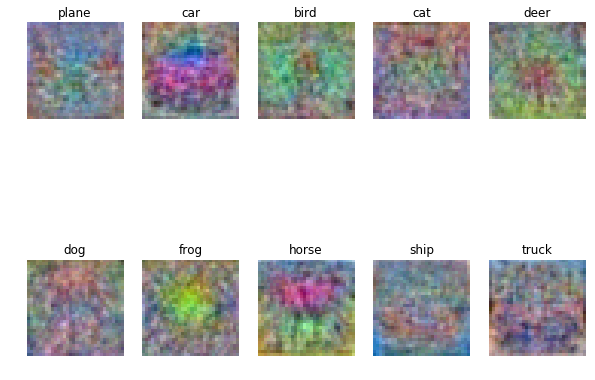

In [216]:
# Visualize the learned weights for each class.

w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [217]:
# Evaluate the best softmax on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'Final test set accuracy using Softmax: %f' % test_accuracy

Final test set accuracy using Softmax: 0.374000
